In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from itertools import permutations, combinations
import pickle
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Descriptors, rdFMCS
import csv
from utilities import *
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [2]:
# Read in csv file of metacyc metabolites from 9 commonly engineered organisms 
metacyc_df = pd.read_csv('metacyc_common_metabolic_compounds_cleaned.csv',delimiter=',')
# import seed database of metabolite synonyms with smiles
SEED_df = pd.read_csv('cleaned_SEED_database_GB_10_10_2023.csv',low_memory=False)
# read in Intermediate Reaction Rules 
all_rules = pd.read_csv('../minedatabase/data/original_rules/JN3604IMT_rules.tsv',sep='\t')
# Read in cofactor data 
all_cofactors = pd.read_csv('../minedatabase/data/original_rules/all_cofactors.tsv',sep='\t')

In [3]:
# Iterate through the Metacyc Dataframe, cleaning smiles, and sorting metabolites by organism 
num_rows = metacyc_df.shape[0] 
all_organisms = set(metacyc_df['Organism']) # each of the organism designations
num_organisms = len(all_organisms)
organism_specific_metabolites = {} # initialize dict to contain each organism subset {'organism id':set(cpd_smiles_1,cpd_smiles_2...)}
# initialize empty subsets
for organism in all_organisms:
    organism_specific_metabolites[organism] = set()
# add compounds to each of the subsets corresponding to each organism 
unique_common_compounds = set() # all unique compounds across the organisms
# iterate thorugh all of the compounds
for i in range(0,num_rows):
    cmpnd = metacyc_df['SMILES'][i] # current compound 
    organism = metacyc_df['Organism'][i] # current organism the metabolite is found in 
    cmpnd_cleaned = clean_smiles(cmpnd,True,True)
    current_organism_set = organism_specific_metabolites[organism] # current set of compounds unique to that organism
    if cmpnd is None: # if we couldn't clean the smiles
        continue 
    else:
        unique_common_compounds.add(cmpnd_cleaned) # add to the overall set for all organisms
        current_organism_set.add(cmpnd_cleaned) # add to specific organism set 
    
print('Total number of unique metabolites:',len(unique_common_compounds))
for organism in all_organisms:
    print(organism,len(organism_specific_metabolites[organism]))

Total number of unique metabolites: 3041
GCF_000014565 1042
GCF_009937745 911
PPUT160488 1325
GCF_000046845 805
MED4 666
MTBH37RV 937
YEAST 973
ECOLI 1985
YARROWIA 977


Number of common metabolites across all 9 species: 330


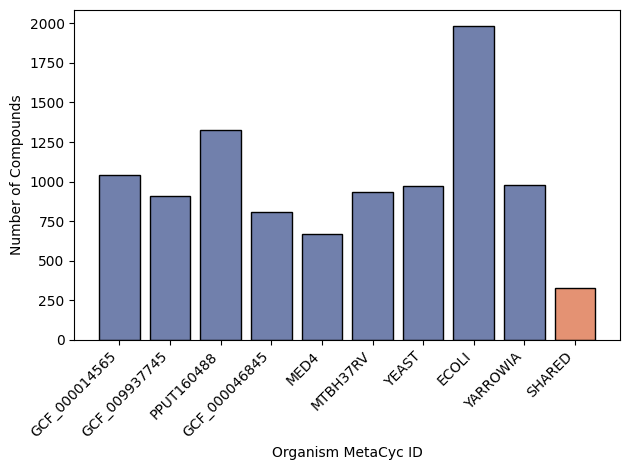

In [ ]:
# Extract keys and corresponding set lengths
organism_names = list(organism_specific_metabolites.keys())
num_metabolites = [len(value) for value in organism_specific_metabolites.values()]
colors = ['#7180AC'] * (len(organism_names))

all_metabolite_sets = list(organism_specific_metabolites.values())
common_metabolites = set.intersection(*all_metabolite_sets)

print("Number of common metabolites across all 9 species:", len(common_metabolites))

organism_names.append('SHARED')
num_metabolites.append(len(common_metabolites))
colors = ['#7180AC'] * (len(organism_names) - 1) + ['#E49273']

plt.bar(organism_names,num_metabolites, color=colors,edgecolor='black')
# Adding labels and title
plt.xlabel('Organism MetaCyc ID')
plt.ylabel('Number of Compounds')
plt.xticks(rotation=45, ha='right')  # Adjust the rotation angle as needed
plt.tight_layout()
plt.savefig('common_metabolites.png')
# Display the plot
plt.show()

In [5]:
# initialize a dictionary to hold reaction id's that map to each rule 
rule_rxn_dict = {} # dictionary: {rule_id:[KEGGRXN1,MCRXN37,BRENDARXN62]...}
for i in range(0,all_rules.shape[0]):
    rule_name = all_rules['Name'][i]
    rule_rxn_dict[rule_name] = []

In [6]:
def read_in_mapped_reactions(file_path,mapping_dict):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            mapped_rxn = row[0]
            for rule in row[1:]:
                mapping_dict[rule].append(mapped_rxn)

    file.close()
    return mapping_dict

In [7]:
# add metacyc, brenda, kegg reaction ids to the rule_rxn_dict {rule_id:[KEGGRXN1,MCRXN37,BRENDARXN62]...}
rule_rxn_dict= read_in_mapped_reactions('mapping_data/mapping_mc_221214_imt_rules_enforce_cof.csv',rule_rxn_dict)
rule_rxn_dict= read_in_mapped_reactions('mapping_data/mapping_brenda_imt_rules_enforce_cof.csv',rule_rxn_dict)
rule_rxn_dict= read_in_mapped_reactions('mapping_data/mapping_kegg_imt_rules_enforce_cof.csv',rule_rxn_dict)

In [8]:
# Read in the reaction data from each database stored as 
# {'RXNID':[{RCTNT1_ID:RCTNT_1_SMILES,...},{PRDCT1_ID:PRDCT_1_SMILES,...}],...}

# Read in metacyc reaction data 
with open('mapping_data/mc_v21_as_is.json', 'r') as json_file:
    mc_rxn_data = json.load(json_file)
json_file.close()

# Read in brenda reaction data 
with open('mapping_data/brenda_as_is.json', 'r') as json_file:
    brenda_rxn_data = json.load(json_file)
json_file.close()

# Read in kegg reaction data 
with open('mapping_data/kegg_as_is.json', 'r') as json_file:
    kegg_rxn_data = json.load(json_file)
json_file.close()

In [9]:
# add all the reaction metadata (metadata id: smiles) to a single dictionary 
all_mapped_rxns = mc_rxn_data.copy()  # Start with a copy of the first dictionary
all_mapped_rxns.update(brenda_rxn_data)   # Update with the second dictionary
all_mapped_rxns.update(kegg_rxn_data)   # Update with the third dictionary
print('Number of mapped reactions (with duplicates):',len(all_mapped_rxns))

Number of mapped reactions (with duplicates): 91034


In [10]:
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        molecular_weight = Descriptors.MolWt(mol)
        return molecular_weight
    else:
        return None
    

def get_eligible_helpers(rxn_list,smarts,potential_helpers):
    '''
    Find the helper molecules for a given reaction rule
    rxn_list: [{rctnts_id:[smiles]},{prdcts_id:[smiles]}]
    smarts: str, rule smarts
    potential_helpers: ['smiles']
    '''
    eligible_helpers = set() # set of unique helper molecules
    reactants_smiles = list(rxn_list[0].values())
    # if this reactant isn't fully specified, skip it
    for rctnt_smile in reactants_smiles:
        if '*' in rctnt_smile:
            return None # can't pass it through the smarts
    reactants_smiles_cleaned = [clean_smiles(i,True,True) for i in reactants_smiles] # remove stereochemistry and charges from reactants
    try:
        reactants_mols = tuple([Chem.MolFromSmiles(elmnt) for elmnt in reactants_smiles_cleaned]) # Convert reactant smiles to mol obj
    except:
        return None 
    operator = Chem.rdChemReactions.ReactionFromSmarts(smarts) # Make reaction object from smarts string
    # iterate through the permutations of the reaction objects to match the smarts entries
    possible_candidates = [] # all smiles that can act as a helper molecule
    for perm in permutations(reactants_mols):
        try:
            products_mol = operator.RunReactants(perm) # Apply operator to that permutation of reactants
        except:
            continue
        if len(products_mol) != 0: # if we found a product 
            reactant_smiles_confirmed = [Chem.MolToSmiles(i) for i in perm] # get smiles of the reactants in the correct order of the operator 
            # iterate through these reactants to check if any of them are in my common compound list 
            for i in range(0,len(reactant_smiles_confirmed)):
                candidate_b = reactant_smiles_confirmed[i]
                possible_candidates.append(candidate_b)
                # if this molecule has been designated as a potential helper (i.e. a common metabolite) add it to our final list of eligible helper molecules
                if candidate_b in potential_helpers: 
                    eligible_helpers.add(candidate_b)
    # if we found no eligible helpers for this rule (not a common metabolite)
    # but we still want to take a helper molecule from the known reactions          
    if len(eligible_helpers) == 0 and len(possible_candidates) > 0: 
        for candidate_b in possible_candidates: 
            mw = calculate_molecular_weight(candidate_b)
            if mw is not None:
                # somewhat arbitrary size limit on the helper molecule
                if mw < 400:
                    eligible_helpers.add(candidate_b)
                    
    return eligible_helpers    

In [11]:
# create a dictionary that will hold the helper molecules (new cofactors) for any;any rules
rule_helper = {} # {rule_name:set(helper_smiles)}
num_any_anys = 0 # all any;any rules
num_any_anys_mapped = 0 # any;any rules that have a known mapped reaction 
num_any_anys_w_helper = 0 # any;any rules that have a helper molecule

# iterate through all of the rules
for i in range(0,all_rules.shape[0]):
    reactant_pair = all_rules['Reactants'][i] # Any;Any, Any;Any;NADH, Any;NADH etc
    individual_reactants = reactant_pair.split(';')
    num_anys = individual_reactants.count('Any')
    if num_anys > 1: # if we have an any;any rule
        num_any_anys += 1
        rule_name = all_rules['Name'][i]
        rule_helper[rule_name] = set() # create a set of POTENTIAL helper molecules for this rule
        if len(rule_rxn_dict[rule_name]) > 0: # if we have a reaction mapped to this rule
            num_any_anys_mapped += 1
            rule_smarts = all_rules['SMARTS'][i]
            mapped_reactions = rule_rxn_dict[rule_name] # list of KBM reaction ids
            for rxn in mapped_reactions:
                rxn_name = rxn.strip('|') # for metacyc reactions
                if rxn_name in all_mapped_rxns: # we have the reactant and product smiles for this reaction
                    rxn_rctnt_prdct_pair = all_mapped_rxns[rxn_name] # this is a list of dicts
                    eligible_helpers = get_eligible_helpers(rxn_rctnt_prdct_pair,rule_smarts,common_metabolites)
                    if eligible_helpers is None:
                        continue
                    elif len(eligible_helpers) > 0:
                        rule_helper[rule_name] = rule_helper[rule_name].union(eligible_helpers)

At this point we have assembled a list of helper molecules for all of the any;any reactions that we can. This method prioritizes using substrates that have been designated a "common metabolite" by me (GB). In this way we try to avoid including substrates that are too funky. For example say rule 1 maps RXN_I (A+B->) and RXN_J (C+D->). If A, B and C are common metabolites then they are the ones selected as helper molecules. However if A, B, C, and D are all NOT common metabolites then any of them with mw < 400 g/mol will be selected as potential helper moelcules. The total number of helper molecules will be slimmed down in the subsequent code.

In [12]:
num_any_anys_w_helper = 0 

for rule_name in rule_helper:
    num_helpers = len(rule_helper[rule_name])
    if num_helpers > 0:
        num_any_anys_w_helper += 1

print('Total number of any;any rules:',num_any_anys)
print('Total number of any;any rules that have a mapped reaction:',num_any_anys_mapped)
print('Number of any;any rules I found a helper molecule for:',num_any_anys_w_helper)
print('Sucess rate:',round(num_any_anys_w_helper/num_any_anys_mapped,4))

Total number of any;any rules: 1018
Total number of any;any rules that have a mapped reaction: 897
Number of any;any rules I found a helper molecule for: 822
Sucess rate: 0.9164


In [13]:
with open('all_common_metabolites_that_are_helpers.pkl', 'wb') as file:
    pickle.dump(rule_helper, file) # {rule_name:set(helper_smiles)}

The following section is dedicated to slimming down the list of helper molecules that have been previously mined for the JN3604 intermediate rule set. The way this is done is by specifying a target molecule for the expansion. The list is then generated by looking at knwon reactions mapped by our rules. From a list of say, 4 potential helper molecules, I select the single helper molecule that, when reacted in its native reaction, results in a product molecule that shares a maximum common substructure with the target molecule. In this way the reactions we generate a more "targeted" than just breadth-first search. 

In [14]:
with open('all_common_metabolites_that_are_helpers.pkl', 'rb') as file:
    rule_helper = pickle.load(file) # {rule_name:set(helper_smiles)}

In [15]:
def apply_rule(smarts,reactants_smiles):
    reactants_smiles_cleaned = [clean_smiles(i,True,True) for i in reactants_smiles] # remove stereochemistry and charges from reactants
    try:
        reactants_mols = tuple([Chem.MolFromSmiles(elmnt) for elmnt in reactants_smiles_cleaned]) # Convert reactant smiles to mol obj
    except:
        return None
    operator = Chem.rdChemReactions.ReactionFromSmarts(smarts) # Make reaction object from smarts string
    # iterate through the permutations of the reaction objects to match the smarts entries
    all_products = []

    for perm in permutations(reactants_mols):
        try:
            products_mol = operator.RunReactants(perm) # Apply operator to that permutation of reactants
        except:
            continue
        
        all_products.append(products_mol)

    return all_products

In [16]:
def get_mcs_score(rc1,rc2):

    res = rdFMCS.FindMCS([rc1, rc2], 
                                    bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                                    atomCompare=rdFMCS.AtomCompare.CompareElements,
                                    matchValences=False, 
                                    matchChiralTag=False,
                                    ringMatchesRingOnly=False,
                                    completeRingsOnly=True,
                                    timeout=1
                        )
    if res.canceled:
        print('FAILED MCS')
        return 0
    else:
        mcs_idx, tot = res.numAtoms, max(rc1.GetNumAtoms(), rc2.GetNumAtoms())
        return mcs_idx/tot

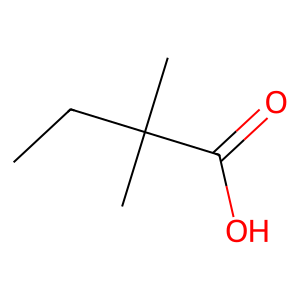

In [17]:
target_smiles = 'OC(C(C)(C)CC)=O'
target_name = 'DMB'
draw_molecule(target_smiles,(300,300))
target_mol = Chem.MolFromSmiles(target_smiles)

In [18]:
# The following code takes 5+ mins to run

# iterate though my rule_helper list and trim it down to match the current expansion
rule_helper_trimmed = {}

for rule_name in rule_helper:
    print(rule_name)
    # get the rule metadata
    rule_index = all_rules.loc[all_rules['Name'] == rule_name].index[0]
    rule_smarts = all_rules['SMARTS'][rule_index]
    rule_reactants = (all_rules['Reactants'][rule_index]).split(';')
    rule_cofactors = [item for item in rule_reactants if item != 'Any']
    
    # get the predetermined cofactors 
    cofactors = []
    if rule_cofactors != []:
        for cof_id in rule_cofactors:
            cof_index = all_cofactors.loc[all_cofactors['#ID'] == cof_id].index[0]
            cof_smiles = all_cofactors['SMILES'][cof_index]
            cofactors.append(cof_smiles)

    # get the helper molecules fro thsi rule 
    helpers = rule_helper[rule_name]
    # if there's more than 1 helper 
    top_mcs = 0
    top_helpers = []
    
    # if we have more than one helper 
    if len(helpers) > 1:
        # get all combimations of them 
        helper_combinations = list(combinations(helpers, 2))
        for helper_combo in helper_combinations:
            test_reactants = cofactors + list(helper_combo)
            all_products = apply_rule(rule_smarts,test_reactants)
            # if we got products 
            if len(all_products) > 0:
                # iterate through each group of products generated
                for i in range(0,len(all_products)):
                    test_product_list = all_products[i]
                    #print(test_product_list)
                    # iterate through the individual products generated 
                    for j in range(0,len(test_product_list)):
                        product_mol_list = test_product_list[j]
                        for product_mol in product_mol_list:
                            #print(product_mol)
                            curr_mcs_score = get_mcs_score(product_mol,target_mol)
                            if curr_mcs_score > top_mcs:
                                top_mcs = curr_mcs_score
                                top_helpers = list(helper_combo)

        rule_helper_trimmed[rule_name] = top_helpers                
    # else we just select that one helper we found
    else:
        rule_helper_trimmed[rule_name] = rule_helper[rule_name]


rule0001_01
rule0001_02
rule0001_03
rule0001_04
rule0001_05
rule0001_06
rule0001_07
rule0001_08
rule0001_09
rule0001_10
rule0001_11
rule0001_12
rule0001_13
rule0001_14
rule0001_15
rule0001_16
rule0001_17
rule0001_18
rule0001_19
rule0001_20
rule0001_21
rule0001_22
rule0001_23
rule0001_24
rule0001_25
rule0001_26
rule0001_27
rule0001_28
rule0001_29
rule0001_30
rule0001_31
rule0001_32
rule0001_33
rule0001_34
rule0001_35
rule0001_36
rule0001_37
rule0001_38
rule0001_39
rule0001_40
rule0001_41
rule0001_42
rule0001_43
rule0001_44
rule0001_45
rule0001_46
rule0001_47
rule0001_48
rule0001_49
rule0001_50
rule0001_51
rule0001_52
rule0001_53
rule0001_54
rule0001_55
rule0001_56
rule0001_57
rule0001_58
rule0001_59
rule0001_60
rule0001_61
rule0001_62
rule0001_63
rule0001_64
rule0001_65
rule0001_66
rule0001_67
rule0001_68
rule0001_69
rule0001_70
rule0001_71
rule0001_72
rule0001_73
rule0001_74
rule0001_75
rule0001_76
rule0001_77
rule0001_78
rule0001_79
rule0001_80
rule0001_81
rule0001_82
rule0001_83
rule

In [19]:
def replace_any(original_reactants,replacement):
    # Find the indices of the occurrences
    first_index = original_reactants.find('Any')
    second_index = original_reactants.find('Any', first_index + 1)

    # Perform the replacement
    if second_index != -1:
        result_string = (
            original_reactants[:second_index] +
            replacement +
            original_reactants[second_index + len('Any'):]
        )
    else:
        # Handle the case where there is no second occurrence
        result_string = original_reactants
    
    return result_string

In [20]:
def get_df_index(pd_df,column,search_object):
    # Use the loc accessor to find the index of the row where the object is present in a specific column
    index_found = pd_df.loc[pd_df[column] == search_object].index
    if index_found.empty:
        return None
    else:
        return index_found[0]

def add_rule(df,name,rctnts,smarts,prdcts,comments):
    # New row data
    new_row_data = {'Name': name,'Reactants': rctnts,'SMARTS': smarts,'Products': prdcts,'Comments': comments}
    # Use loc to add the new row
    df_new_row = pd.DataFrame([new_row_data])

    # Concatenating the original DataFrame with the new DataFrame
    df = pd.concat([df, df_new_row], ignore_index=True)
    return df

def add_cofactor(df, new_id, new_name, new_smiles):
    new_row_data = {'#ID': new_id, 'Name': new_name, 'SMILES':new_smiles}
    # Use loc to add the new row
    df_new_row = pd.DataFrame([new_row_data])
    # Concatenating the original DataFrame with the new DataFrame
    df = pd.concat([df, df_new_row], ignore_index=True)
    return df

In [21]:
# take the original rule and cofactor list we based this work off of and add the helper molecules 
all_cofactors_copy = all_cofactors.copy() # final cofactor list
all_rules_copy = all_rules.copy() # final rules list

for i in range(0,all_rules.shape[0]):
    # get all parts of the rule
    rule_name = all_rules['Name'][i]
    rule_reactants = all_rules['Reactants'][i] # Any;Any, Any;Any;NADH, Any;NADH etc
    rule_smarts = all_rules['SMARTS'][i]
    rule_products = all_rules['Products'][i]
    rule_comments = all_rules['Comments'][i]
    # if our current rule has a known helper molecule
    if rule_name in rule_helper_trimmed:
        # get list of those helpers
        helpers = list(rule_helper_trimmed[rule_name])
        #helpers = list(rule_helper[rule_name])
    else: # we don't need to change anything
        continue

    # iterate through helper molecules
    for j in range(0,len(helpers)): 
        helper_smiles = helpers[j]
        # if this helper molecule has already been added get its index 
        known_helper_index = get_df_index(all_cofactors_copy,'SMILES',helper_smiles)
        if known_helper_index is not None:
            cof_id = all_cofactors_copy['#ID'][known_helper_index]
        else: # if we need to designate a new cofactor and append our dataframe
            cof_id = 'Hlpr-' + str(i) + '-' + str(j)
            cof_name = cof_id        
            all_cofactors_copy = add_cofactor(all_cofactors_copy,cof_id,cof_name,helper_smiles)  
        
        new_name = rule_name + '_' + str(i) + '-' + str(j)
        new_reactants = replace_any(rule_reactants,cof_id)
        all_rules_copy = add_rule(all_rules_copy,new_name,new_reactants,rule_smarts,rule_products,rule_comments)
 

In [22]:
final_num_rules = all_rules_copy.shape[0]
final_num_cofactors = all_cofactors_copy.shape[0]

In [23]:
# Write the DataFrame to a TSV file
all_rules_copy.to_csv('../minedatabase/data/A_plus_B_rules/RULES_GB_' + str(final_num_rules) + '_rules_'+ str(final_num_cofactors) + '_cofactors_'+target_name+'.tsv', sep='\t', index=False)
all_cofactors_copy.to_csv('../minedatabase/data/A_plus_B_rules/COFACTORS_GB_' + str(final_num_rules) + '_rules_'+ str(final_num_cofactors) + '_cofactors_'+target_name+'.tsv', sep='\t', index=False)